# `segmed`: Medical image segmentation

`segmed` is a package that makes it very easy to train, evaluate and analyse image segmentation tasks. By using a high-level API, `segmed` can be used to create all kinds of architectures and designs, all custom-built for the end user.

## _Case study:_ The ISBI 2012 image segmentation challenge.

[The ISBI 2012 image segmentation challenge](http://brainiac2.mit.edu/isbi_challenge/home) was launched to motivate people to create machine learning algorithms that could succesfully segment histological images.

In this challenge, a full stack of electronic microscopy (EM) slices were released to train machine learning algorithms for the purpose of automatic segmentation of neural structures.

In this notebook we will use this dataset to train a [U-Net](https://arxiv.org/abs/1505.04597), a fully convolutional neural network designed specifically for image segmentation tasks. We will create a full pipeline to demonstrate how to process the information first and then use `segmed` to create the architecture for us.

## 1. Installation and imports

We follow the instructions from the [main site](https://github.com/DCI-NET/segmed) and install `segmed` using `pip`, `conda` or `pipenv`.

We now import the basic tools that we will need to process everything.

In [1]:
import tensorflow.keras as K
from segmed.models import Unet
from segmed import utils as sut
from segmed.metrics import metrics as mts
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## 2. Extract data and process it.

We now proceed to extract the data from the official site, in this case we have already done this and saved the dataset in a Google Drive account. To actually download this one must create an account in the [home page](http://brainiac2.mit.edu/isbi_challenge/home) of the challenge.

The dataset consists of 30 images and its segmentation masks, as defined by the website.

### Training parameters
In this case we define only 30 training epochs and a batch size of 8, this is after all a small dataset with only 30 training images.

In [2]:
# Define some hyper-paramaters
epochs = 30
batch_size = 8

`extract_data` is a utility from `segmed` that makes it extremely easy to turn entire directory structures into `numpy` arrays. This function can handle almot every possible format and codification by using `scikit-image`.

In [3]:
# Extract images from directory
X, y = sut.extract_data(
    "dataset/train_images/train-volume.tif",
    "dataset/train_images/train-labels.tif"
)
# Let's quickly look at the result
print(X.shape)
print(y.shape)

(1, 30, 512, 1, 512)
(1, 30, 512, 1, 512)


It seems like the encoding format for the images has created some singleton dimensions, but the information for the images is correct, we do have 30 images, each with a dimension of 512 by 512, in grayscale.

Let us remove these redundant dimensions before going any further.

In [4]:
X = np.squeeze(X)
y = np.squeeze(y)
# Much better!
print(X.shape)
print(y.shape)

(30, 512, 512)
(30, 512, 512)


## 3. Crop images

In reality, we need smaller images for a neural network because of memory and hardware constraints. 512 by 512 images are too big, but using `segmed` we can `split_images` into smaller, randomly cropped images of the original ones.

In [5]:
x_patches, y_patches = sut.split_images(
    X, y, size=(128, 128), num_part=4
)
print(x_patches.shape)
print(y_patches.shape)

(120, 128, 128, 1)
(120, 128, 128, 1)


We now have 120, 128 by 128, grayscale images from the original 30. This is helpful, because we have quadruplicated our dataset. This will help prevent overfitting and have a better generalization.

In this case there is a new singleton dimension, but this one we'll keep because it tells us about the **color channels** of the images, i.e. 1 means that the images are _actually_ grayscale.

## 4. Train and validation sets

Now it is time to split the dataset into training and validation sets, using `scikit-learn` we can do this in one line.

We specify that we want 70% of the full dataset, i.e. 84 images, for the **training** set, and the other 36 for the **validation** set. We also specify a _random seed_ for reproducibility purposes.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(x_patches, y_patches,
                                                 test_size=0.3,
                                                 random_state=298)
# Check the number of images and their segmentation maps for each set
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(84, 128, 128, 1) (84, 128, 128, 1)
(36, 128, 128, 1) (36, 128, 128, 1)


## 5. Data augmentation

Even though we created more images by cropping theme, this is not enough. To further create more images that can be useful for training purposes we need to _augment_ the data we have by using some elementary image transformation, such as rotation, translations, shifts and so on.

This does not only expand our dataset, but will make the architecture robust to this transformations.

Keep in mind we will only transform the **training** set.

In [7]:
transformations = dict(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=25.0,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # set range for random shear
    shear_range=50,
    # set range for random zoom
    zoom_range=0.2,
    fill_mode="constant",
    horizontal_flip=True,
    vertical_flip=True
)

Now we will use `segmed` to create training _generator_ based off of these transformations. The utility `image_mask_augmentation` makes it very easy to achieve this task.

These transformations are performed _on the fly_, i.e. while the training loop is performed the images are transformed randomly with the specified transformations.

In [8]:
# Transformed traning set
training = sut.image_mask_augmentation(X_train, y_train,
                                       batch_size=batch_size,   
                                       transformations=transformations)

## 6. Architecture setup

We'll now define some useful callback provided by the `keras` API, namely a model checkpoint to always keep a copy of the best trained model, as well as a logger to keep track of all the metrics we'll be using here.

In [9]:
# Create callbacks
save_best_model = K.callbacks.ModelCheckpoint("unet_simple_new.h5",
                                 monitor="val_jaccard_index",
                                 mode="max",
                                 verbose=1,
                                 save_best_only=True,
                                )
csv_logger = K.callbacks.CSVLogger("unet_simple_new.log")

## 7. Architecture specification

The U-Net is a very specific architecture, and `segmed` has an implementation of it. It follows the original paper closely, and this implementation provides a _simple_ variant and a _custom_ variant. We will be using the _simple_ variant here, i.e. the one defined in the original paper.

For metrics we chose the [**jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index) which is a very standard metric for segmentation tasks; the **over, under and overall** segmentation rates, which are more clearly defined [in this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1839603/pdf/AMIA2006_0504.pdf). This metrics tell us how good are segmentation maps are, between a range of 0 and 1, lower means better.

For the loss function, we will employ **binary crossentropy**, as we only have two possible classes here, either a border or not whitin the segmentation masks. 

For the optimizer we chose the efficient **Adam with Nesterov momentum.** This optimizer is great for these kind of networks because it helps us reach a global minimum faster.

In [10]:
# U-net
model_unet = Unet(input_size=(128, 128, 1), variant="simple").collect()
# This is now a `Keras model`
model_unet.compile(
    loss="binary_crossentropy",
    optimizer=K.optimizers.Nadam(),
    metrics=[mts.jaccard_index, mts.o_rate, mts.u_rate, mts.err_rate],
)

In [11]:
model_unet.summary()

Model: "unet_simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

This is a _big_ network, 31+ million parameters to train, but worry not, because although we might be prone to some overfitting, the generalization of the network will be quite fine.

## 7. Training

This is the big moment, let us now train the network.

In [12]:
history = model_unet.fit_generator(
    # Extract the tuples from the generator
    ((i) for i in training),
    epochs=epochs,
    steps_per_epoch=20,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[save_best_model, csv_logger],
)

Epoch 1/30
19/20 [===========================>..] - ETA: 9s - loss: 1.0815 - jaccard_index: 0.5183 - o_rate: 35.5308 - u_rate: 0.0352 - err_rate: 201.3448 
Epoch 00001: val_jaccard_index improved from -inf to 0.70905, saving model to unet_simple_new.h5
20/20 [==============================] - 201s 10s/step - loss: 1.0554 - jaccard_index: 0.5246 - o_rate: 33.7548 - u_rate: 0.0349 - err_rate: 191.2801 - val_loss: 0.4947 - val_jaccard_index: 0.7090 - val_o_rate: 7.7526e-05 - val_u_rate: 0.0365 - val_err_rate: 0.0485
Epoch 2/30
19/20 [===========================>..] - ETA: 9s - loss: 1.4368 - jaccard_index: 0.6000 - o_rate: 577.1990 - u_rate: 0.0262 - err_rate: 577.2335 
Epoch 00002: val_jaccard_index did not improve from 0.70905
20/20 [==============================] - 190s 9s/step - loss: 1.3866 - jaccard_index: 0.6055 - o_rate: 548.3392 - u_rate: 0.0264 - err_rate: 548.3739 - val_loss: 0.5819 - val_jaccard_index: 0.5348 - val_o_rate: 0.0848 - val_u_rate: 0.0069 - val_err_rate: 0.0961
Ep

19/20 [===========================>..] - ETA: 8s - loss: 0.2669 - jaccard_index: 0.7676 - o_rate: 0.0108 - u_rate: 0.0144 - err_rate: 0.0282 
Epoch 00018: val_jaccard_index improved from 0.77277 to 0.77677, saving model to unet_simple_new.h5
20/20 [==============================] - 192s 10s/step - loss: 0.2661 - jaccard_index: 0.7689 - o_rate: 0.0108 - u_rate: 0.0142 - err_rate: 0.0279 - val_loss: 0.3143 - val_jaccard_index: 0.7768 - val_o_rate: 0.0060 - val_u_rate: 0.0201 - val_err_rate: 0.0303
Epoch 19/30
19/20 [===========================>..] - ETA: 8s - loss: 0.2585 - jaccard_index: 0.7732 - o_rate: 0.0108 - u_rate: 0.0137 - err_rate: 0.0271 
Epoch 00019: val_jaccard_index did not improve from 0.77677
20/20 [==============================] - 186s 9s/step - loss: 0.2604 - jaccard_index: 0.7714 - o_rate: 0.0107 - u_rate: 0.0137 - err_rate: 0.0272 - val_loss: 0.3092 - val_jaccard_index: 0.7507 - val_o_rate: 0.0135 - val_u_rate: 0.0146 - val_err_rate: 0.0313
Epoch 20/30
19/20 [========

There is a lot of output here, but it's better this way in order to keep track of overfitting and such. But it's _even better_ to create to plots about it.

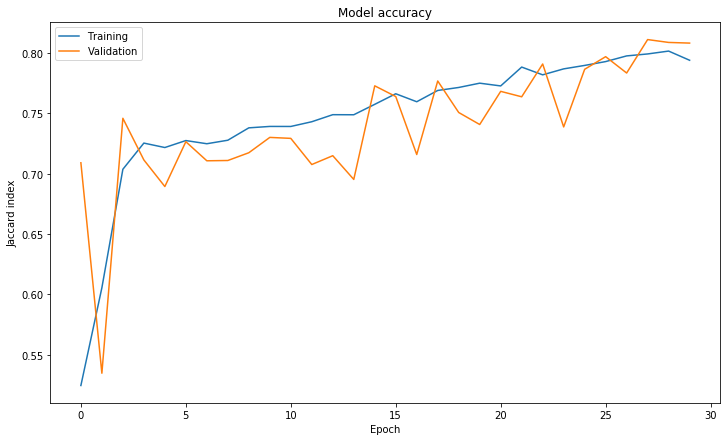

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(history.history["jaccard_index"])
plt.plot(history.history["val_jaccard_index"])
plt.title("Model accuracy")
plt.ylabel("Jaccard index")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

There is **overfitting** as expected, but the generalization is good for just some epochs and minimal data augmentation. We see the _validation_ accuracy go all over the place mainly because of the small value of the _batch size._ This should be enough to prove our point, though.

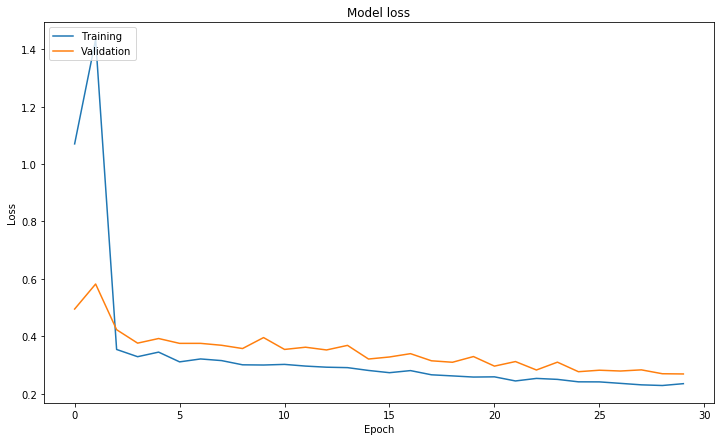

In [14]:
plt.figure(figsize=(12, 7))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

The _loss_ is nice and steady, maybe some more 10 epochs and we could have achieved a better result. Keep in mind that the more epochs the more likely it is to get stuck in a plateau somewhere and just waste time training and not getting better results.

## 8. Results

Let us now inspect our results with some testing data. These images were **never** seen by the neural network, so we expect it to segment quite well, with a few mishaps here and there. After all, we got a 80% Jaccard index which is nice for the very small dataset, but is nowhere near the state-of-the-art results we could actually achieve.

Because this is a _new_ dataset, we need to load it and process it like before. I added an additional step to include the _color channel_ information.

In [15]:
X_test = sut.extract_data("dataset/test_images/test-volume.tif")
X_test = np.squeeze(X_test)
# Add a new axis to specify grayscale
X_test = X_test[..., np.newaxis]

Right now, the `segmed` API expects the same size of input for prediction, and the new data are another 30 images with dimensions 512 by 512, so we need to split them again and pass them on to the best model trained.

In [16]:
x_test_patches = sut.split_images( X_test, size=(128, 128), num_part=4)

In [28]:
# Load the best model trained
model_unet.load_weights("unet_simple_new.h5")
results = model_unet.predict(x_test_patches, batch_size=batch_size)
print(results.shape)

(120, 128, 128, 1)


The result from this are images in grayscale, so we need to binarize them. I use here [Otsu's method](https://en.wikipedia.org/wiki/Otsu's_method) for thresholding as it is a very robust method, and quite fast to binarize all the images.

In [29]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(X_test[1, ...])
binary = results[...] > thresh

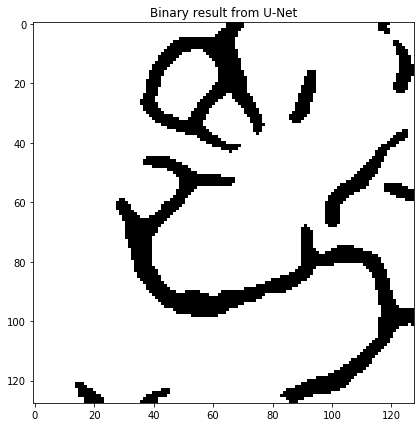

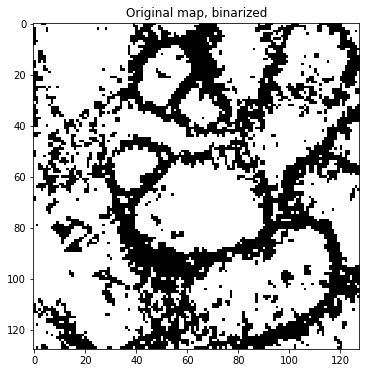

In [45]:
plt.figure(figsize=(12, 7))
plt.title("Binary result from U-Net")
plt.imshow(binary[2, ..., 0], cmap="gray")
plt.figure(figsize=(10, 6))
plt.title("Original map, binarized")
plt.imshow(x_test_patches[2, ..., 0] > thresh, cmap="gray")
plt.show()

## 9. Conclusion

As we can see, the segmentation was carried out successfully. There are some errors in the result obtained, but for the most part the borders and overall regions are very good. Moreover, most of the noise from the original image was ignored; those pixels in the white zones are not really relevant in the image as a whole, and the U-Net knew this.

Further **data augmentation**, **training time** and **overfitting control** can enhance these results, and almost everything can be done with the `segmed` API.